# Classifying Potholes

Note that the structure of the folders needs to be as follows:  
├── Images  
│   ├── Training  
│   |      └── normal  
│   |      └── potholes   
│   └── Validation    
│   |      └── normal    
│   |      └── potholes    
└── README.md  

https://www.kaggle.com/pradneshmhatre/pothole-detector-with-keras

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, LeakyReLU
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.math import tanh, softplus
from tensorflow.math import sigmoid
import os
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import cv2
import pandas as pd
from random import randint

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix

import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
%matplotlib inline


def resize_image(image_path, image_size):   
    img = cv2.imread(image_path,cv2.IMREAD_COLOR)
    img = cv2.resize(img, (image_size, image_size))
    return np.array(img)


def prepare_data(image_size):
    
    image_paths = [os.path.join(root, file) 
                   for root, _, files in os.walk(os.path.abspath("Images/")) 
                   for file in files]

    X_train, X_test, y_train, y_test = [], [], [], []

    for image_path in image_paths:
        try:
            img = resize_image(image_path, image_size)

            if "Training" in image_path:
                X_train.append(img)

                if "potholes" in image_path:
                    y_train.append("Pothole")
                else:
                    y_train.append("Normal")

            elif "Validation" in image_path:
                X_test.append(img)

                if "potholes" in image_path:
                    y_test.append("Pothole")
                else:
                    y_test.append("Normal")
        except Exception as e:
            pass

    X_train = np.array(X_train)
    X_test = np.array(X_test)
    y_train = np.array(y_train)
    y_test = np.array(y_test)
    
    return X_train, X_test, y_train, y_test


def show_random_images():
    fig,ax=plt.subplots(2,5)
    plt.subplots_adjust(bottom=0.3, top=0.7, hspace=0)
    fig.set_size_inches(15,15)

    for i in range(2):
        for j in range (5):
            l=randint(0,len(y_train))
            ax[i,j].imshow(X_train[l][:,:,::-1])
            ax[i,j].set_title(y_train[l])
            ax[i,j].set_aspect('equal')
            

def swish(x, beta = 1):
    return (x * sigmoid(beta * x))


def mish(inputs):
    return inputs * tanh(softplus(inputs))


def create_model(activation, input_shape):
    # Create a CNN Sequential Model
    model = Sequential()

    model.add(Conv2D(32, (5,5), activation=activation, input_shape=input_shape))
    model.add(MaxPooling2D((2,2)))

    model.add(Conv2D(64, (3, 3), activation=activation)) 
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(128, (3, 3), activation=activation)) 
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(128, (3, 3), activation=activation)) 
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(128, (3, 3), activation=activation)) 
    model.add(MaxPooling2D((2, 2)))

    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(128, activation=activation))
    model.add(Dense(1, activation='sigmoid'))
    
    return model


def create_generators(train_dir = 'Images/Training', test_dir = 'Images/Validation', target_size=(300, 300)):
    train_datagen = ImageDataGenerator(rescale=1. / 255)
    train_generator = train_datagen.flow_from_directory(directory=train_dir,
                                                        target_size=target_size,
                                                        batch_size=12,
                                                        class_mode='binary')

    validation_datagen = ImageDataGenerator(rescale=1. / 255)
    validation_generator = validation_datagen.flow_from_directory(directory=test_dir,
                                                                  target_size=target_size,
                                                                  batch_size=12,
                                                                  class_mode='binary')
    
    return train_generator, validation_generator

def plot_results(model, name, save=False):
    acc = model.history.history['acc']
    loss = model.history.history['loss']
    val_loss = model.history.history['val_loss']
    val_acc = model.history.history['val_acc']
    plt.figure(figsize=(10,5))
    # plot loss during training
    plt.subplot(211)
    plt.suptitle(name+"\n\n", fontsize=18)
    plt.title('\nLoss')
    plt.plot(loss, label='train')
    plt.plot(val_loss, label='test')
    plt.legend()

    # plot accuracy during training
    plt.subplot(212)
    plt.title('Accuracy')
    plt.plot(acc, label='train')
    plt.plot(val_acc, label='test')
    plt.legend()
    plt.tight_layout()
    
    if save:
        plt.savefig(save, dpi=300)
    else:
        plt.show()
    
def compare_result(models, model_names, measure='acc', plot_eval=False, save=False):
    
    fig = plt.figure(figsize=(10,5))
    ax = plt.subplot(111)
    

    for model, name in zip(models, model_names):
        acc = model.history.history['acc']
        loss = model.history.history['loss']
        val_loss = model.history.history['val_loss']
        val_acc = model.history.history['val_acc']

        x = np.arange(0, len(acc))
        if measure == 'acc':
            if plot_eval:
                ax.plot(x, val_acc, label=name+" Eval", linestyle="--")
            else:
                ax.plot(x, acc, label=name+" Train", linestyle="-")
        else:
            if plot_eval:
                ax.plot(x, val_loss, label=name+" Eval", linestyle="--")
            else:
                ax.plot(x, loss, label=name+" Train", linestyle="-")
    ax.legend()
    
    if save:
        plt.savefig(save, dpi=300)
    else:
        plt.show()
        
def save_results(models, names, save_name):
    results = {}
    for model, name in zip(models, names):
        results[name] = model.history.history

    with open(f'{save_name}.pkl', 'wb') as f:
        pickle.dump(results, f)

## Custom CNN - Relu vs. Mish vs. Gelu vs. Swish
Starting with mostly manual work to get a feeling for using these networks

### Prepare Data

In [2]:
X_train, X_test, y_train, y_test = prepare_data(image_size=150)

### Display Data

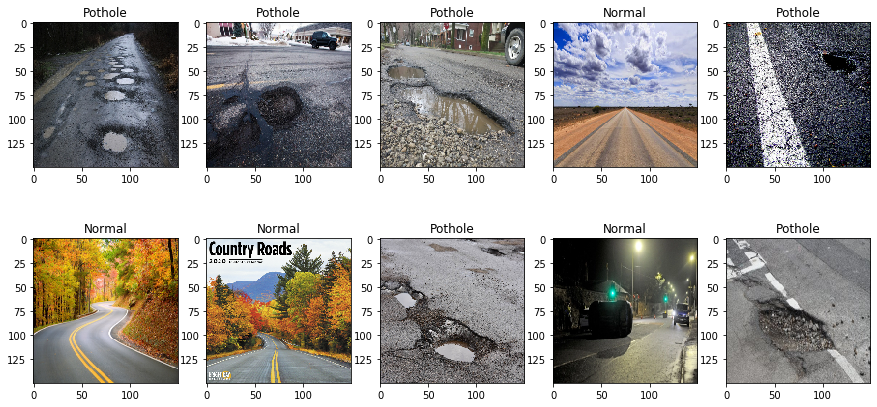

In [3]:
show_random_images()

### Split Data

In [4]:
# Label encode y
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

### Models

In [7]:
input_shape = X_train[0].shape

# Relu
model_relu = create_model('relu', input_shape)
model_relu.compile(optimizer=RMSprop(lr=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Leaky
model_leaky = create_model(LeakyReLU(), input_shape)
model_leaky.compile(optimizer=RMSprop(lr=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Swish
model_swish = create_model(swish, input_shape)
model_swish.compile(optimizer=RMSprop(lr=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Mish
model_mish = create_model(mish, input_shape)
model_mish.compile(optimizer=RMSprop(lr=0.001), loss='binary_crossentropy', metrics=['accuracy'])


print(model_relu.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 146, 146, 32)      2432      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 73, 73, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 71, 71, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 35, 35, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 33, 33, 128)       73856     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 14, 14, 128)      

### Fit all Models

In [12]:
model_relu.fit(X_train, y_train, epochs=30, batch_size=12, validation_data=(X_test, y_test))
model_leaky.fit(X_train, y_train, epochs=30, batch_size=12, validation_data=(X_test, y_test))
model_swish.fit(X_train, y_train, epochs=30, batch_size=12, validation_data=(X_test, y_test))
model_mish.fit(X_train, y_train, epochs=30, batch_size=12, validation_data=(X_test, y_test))

Train on 580 samples, validate on 100 samples
Epoch 1/30
580/580 [==============================] - 10s 18ms/sample - loss: 0.7353 - acc: 0.6000 - val_loss: 0.6435 - val_acc: 0.7400
Epoch 2/30
580/580 [==============================] - 10s 17ms/sample - loss: 0.7520 - acc: 0.6224 - val_loss: 1.9258 - val_acc: 0.5200
Epoch 3/30
580/580 [==============================] - 10s 17ms/sample - loss: 0.6682 - acc: 0.6655 - val_loss: 1.3260 - val_acc: 0.5000
Epoch 4/30
580/580 [==============================] - 10s 17ms/sample - loss: 0.6441 - acc: 0.6621 - val_loss: 4.6514 - val_acc: 0.5000
Epoch 5/30
580/580 [==============================] - 10s 17ms/sample - loss: 0.6855 - acc: 0.7431 - val_loss: 0.8489 - val_acc: 0.6500
Epoch 6/30
580/580 [==============================] - 10s 17ms/sample - loss: 0.6072 - acc: 0.7259 - val_loss: 0.5296 - val_acc: 0.7700
Epoch 7/30
580/580 [==============================] - 10s 17ms/sample - loss: 0.5266 - acc: 0.7759 - val_loss: 0.5614 - val_acc: 0.7800
Ep

580/580 [==============================] - 10s 18ms/sample - loss: 0.3415 - acc: 0.9207 - val_loss: 0.8409 - val_acc: 0.8500
Train on 580 samples, validate on 100 samples
Epoch 1/30
580/580 [==============================] - 13s 23ms/sample - loss: 3.3620 - acc: 0.5724 - val_loss: 0.6736 - val_acc: 0.5500
Epoch 2/30
580/580 [==============================] - 13s 22ms/sample - loss: 0.7640 - acc: 0.6172 - val_loss: 0.7057 - val_acc: 0.6500
Epoch 3/30
580/580 [==============================] - 12s 21ms/sample - loss: 0.8645 - acc: 0.5914 - val_loss: 0.6979 - val_acc: 0.5400
Epoch 4/30
580/580 [==============================] - 12s 21ms/sample - loss: 0.6833 - acc: 0.6914 - val_loss: 0.5908 - val_acc: 0.7400
Epoch 5/30
580/580 [==============================] - 12s 21ms/sample - loss: 0.7557 - acc: 0.7138 - val_loss: 0.7717 - val_acc: 0.6300
Epoch 6/30
580/580 [==============================] - 12s 21ms/sample - loss: 0.5887 - acc: 0.7534 - val_loss: 0.5445 - val_acc: 0.7200
Epoch 7/30
58

580/580 [==============================] - 14s 24ms/sample - loss: 0.3803 - acc: 0.8776 - val_loss: 0.6400 - val_acc: 0.8500
Epoch 30/30
580/580 [==============================] - 14s 24ms/sample - loss: 0.3927 - acc: 0.8845 - val_loss: 0.7703 - val_acc: 0.8400


## Results

In [13]:
for model, name in zip([model_relu, model_leaky, model_swish, model_mish], ["Relu", "Leaky Relu", "Swish", "Mish"]):
    print(name)
    loss, accuracy = model.evaluate(X_test, y_test)
    print('{} Test accuracy: {:2.2f}% \n'.format(name, accuracy*100))
    
    predictions = model.predict(X_test).reshape(1, -1)[0]
    predictions = [0 if val < 0.5 else 1 for val in predictions]
    print(confusion_matrix(predictions, y_test, labels=None, sample_weight=None, normalize=None))
    print()

Relu
100/100 [==============================] - 0s 4ms/sample - loss: 0.5874 - acc: 0.8800
Relu Test accuracy: 88.00% 

[[44  6]
 [ 6 44]]

Leaky Relu
100/100 [==============================] - 0s 4ms/sample - loss: 0.8409 - acc: 0.8500
Leaky Relu Test accuracy: 85.00% 

[[41  6]
 [ 9 44]]

Swish
100/100 [==============================] - 1s 5ms/sample - loss: 0.7943 - acc: 0.8100
Swish Test accuracy: 81.00% 

[[33  2]
 [17 48]]

Mish
100/100 [==============================] - 1s 6ms/sample - loss: 0.7703 - acc: 0.8400
Mish Test accuracy: 84.00% 

[[40  6]
 [10 44]]



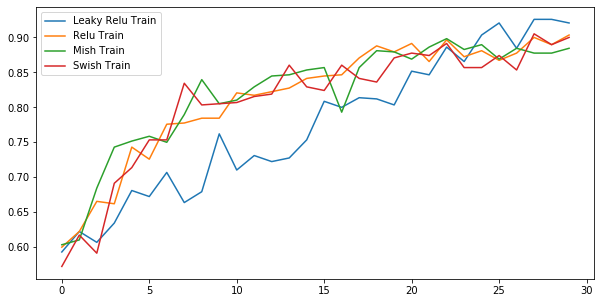

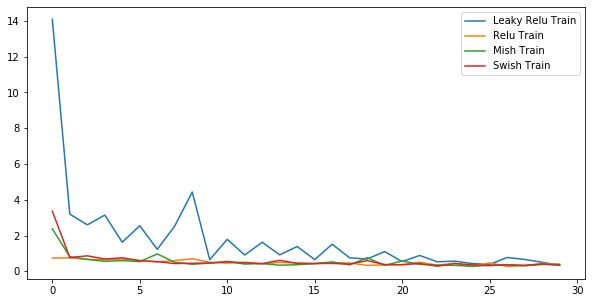

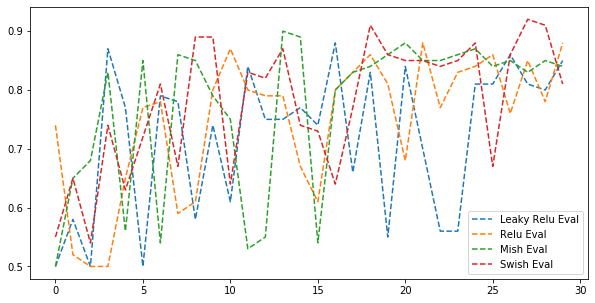

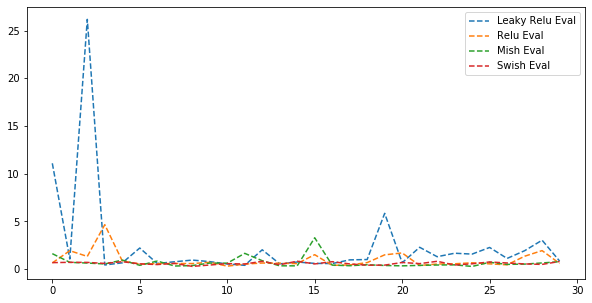

In [82]:
models = [model_leaky, model_relu, model_mish, model_swish]
model_names = ["Leaky Relu", "Relu", "Mish", "Swish"]
compare_result(models, model_names, measure='acc', plot_eval=False, save="acc_train_custom_cnn.png")
compare_result(models, model_names, measure='loss', plot_eval=False, save="loss_train_custom_cnn.png")
compare_result(models, model_names, measure='acc', plot_eval=True, save="acc_test_custom_cnn.png")
compare_result(models, model_names, measure='loss', plot_eval=True, save="loss_test_custom_cnn.png")

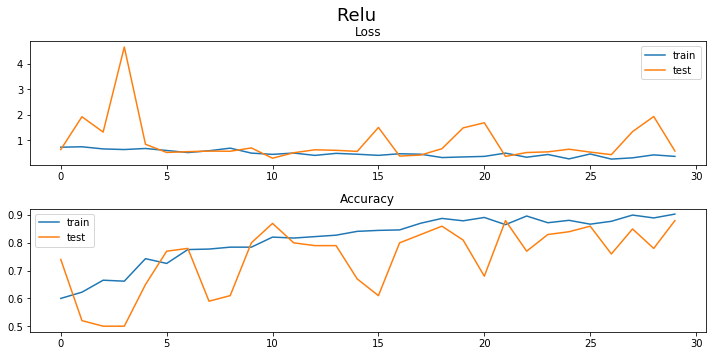

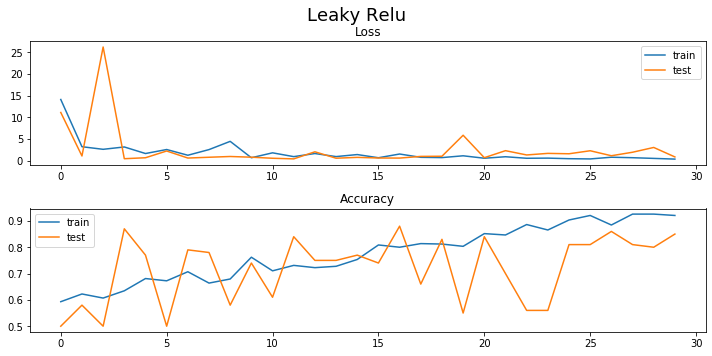

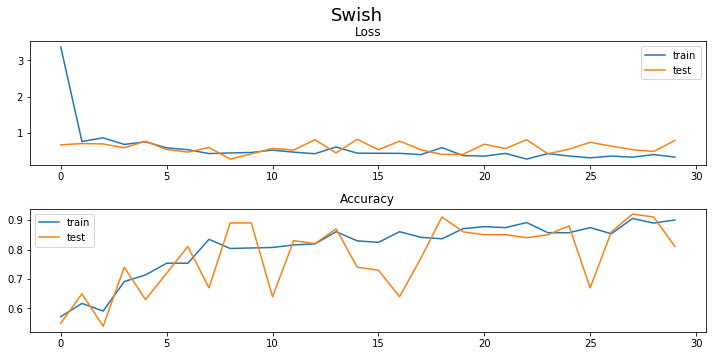

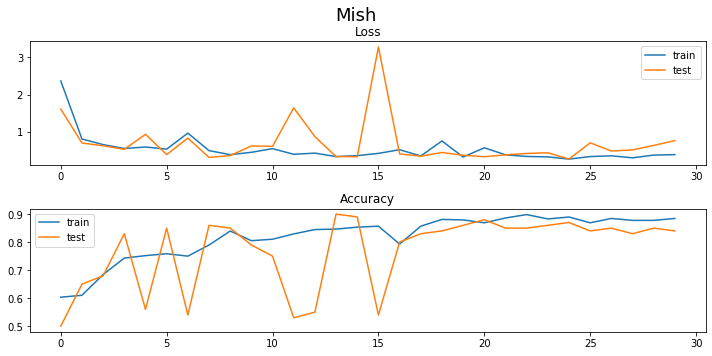

In [63]:
plot_results(model_relu, "Relu")
plot_results(model_leaky, "Leaky Relu")
plot_results(model_swish, "Swish")
plot_results(model_mish, "Mish")

#### Save Results

In [87]:
models = [model_leaky, model_relu, model_mish, model_swish]
model_names = ["Leaky Relu", "Relu", "Mish", "Swish"]
save_results(models, model_names)

# ImageGenerator - Relu vs. Mish vs. Gelu vs. Swish
To do a little more advanced preprocessing

In [2]:
target_size = (150, 150)
train_generator, validation_generator = create_generators(train_dir='Images/Training', 
                                                          test_dir='Images/Validation',
                                                          target_size=target_size)

Found 581 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


In [4]:
input_shape = (150, 150, 3)

# Relu
model_relu = create_model('relu', input_shape)
model_relu.compile(optimizer=RMSprop(lr=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Leaky
model_leaky = create_model(LeakyReLU(alpha=0.2), input_shape)
model_leaky.compile(optimizer=RMSprop(lr=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Swish
model_swish = create_model(swish, input_shape)
model_swish.compile(optimizer=RMSprop(lr=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Mish
model_mish = create_model(mish, input_shape)
model_mish.compile(optimizer=RMSprop(lr=0.001), loss='binary_crossentropy', metrics=['accuracy'])


print(model_relu.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 146, 146, 32)      2432      
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 73, 73, 32)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 71, 71, 64)        18496     
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 35, 35, 64)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 33, 33, 128)       73856     
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 14, 14, 128)      

In [10]:
print(f"Batch Size Train: {train_generator.batch_size}")
print(f"N Size Train: {train_generator.n}\n")
print(f"Batch Size Validation: {validation_generator.batch_size}")
print(f"N Size Validation: {validation_generator.n}")

Batch Size Train: 12
N Size Train: 581

Batch Size Validation: 12
N Size Validation: 100


In [11]:
history = {}
for model, name in zip([model_relu, model_leaky, model_swish, model_mish], 
                       ["Relu", "Leaky Relu", "Swish", "Mish"]):

    history[name] = model.fit_generator(train_generator, 
                                       steps_per_epoch=train_generator.n // train_generator.batch_size, # typically num_samples // batch_size
                                       epochs=30, 
                                       validation_data=validation_generator,
                                       validation_steps=validation_generator.n // validation_generator.batch_size, # typically num_samples // batch_size
                                       verbose=1)

Epoch 1/30
48/48 [==============================] - 20s 424ms/step - loss: 0.6995 - acc: 0.4903 - val_loss: 0.6865 - val_acc: 0.6771
Epoch 2/30
48/48 [==============================] - 20s 426ms/step - loss: 0.7069 - acc: 0.6151 - val_loss: 0.6786 - val_acc: 0.5521
Epoch 3/30
48/48 [==============================] - 21s 431ms/step - loss: 0.6261 - acc: 0.6942 - val_loss: 0.4055 - val_acc: 0.8542
Epoch 4/30
48/48 [==============================] - 20s 420ms/step - loss: 0.5326 - acc: 0.7592 - val_loss: 0.4111 - val_acc: 0.8542
Epoch 5/30
48/48 [==============================] - 20s 410ms/step - loss: 0.5327 - acc: 0.7627 - val_loss: 0.4410 - val_acc: 0.8333
Epoch 6/30
48/48 [==============================] - 20s 409ms/step - loss: 0.4322 - acc: 0.8348 - val_loss: 0.2635 - val_acc: 0.9062
Epoch 7/30
48/48 [==============================] - 19s 389ms/step - loss: 0.4076 - acc: 0.8330 - val_loss: 0.4725 - val_acc: 0.8438
Epoch 8/30
48/48 [==============================] - 20s 408ms/step - 

Epoch 8/30
48/48 [==============================] - 20s 424ms/step - loss: 0.3907 - acc: 0.8559 - val_loss: 0.3227 - val_acc: 0.8646
Epoch 9/30
48/48 [==============================] - 20s 427ms/step - loss: 0.3478 - acc: 0.8559 - val_loss: 0.3276 - val_acc: 0.8750
Epoch 10/30
48/48 [==============================] - 20s 426ms/step - loss: 0.3193 - acc: 0.8770 - val_loss: 0.4577 - val_acc: 0.8333
Epoch 11/30
48/48 [==============================] - 19s 399ms/step - loss: 0.3485 - acc: 0.8752 - val_loss: 0.3124 - val_acc: 0.8958
Epoch 12/30
48/48 [==============================] - 20s 421ms/step - loss: 0.2914 - acc: 0.8858 - val_loss: 0.2372 - val_acc: 0.9167
Epoch 13/30
48/48 [==============================] - 19s 390ms/step - loss: 0.2353 - acc: 0.8963 - val_loss: 0.3837 - val_acc: 0.8750
Epoch 14/30
48/48 [==============================] - 20s 410ms/step - loss: 0.2131 - acc: 0.9358 - val_loss: 0.2129 - val_acc: 0.9167
Epoch 15/30
48/48 [==============================] - 18s 385ms/s

Epoch 15/30
48/48 [==============================] - 19s 391ms/step - loss: 0.1854 - acc: 0.9288 - val_loss: 0.1158 - val_acc: 0.9271
Epoch 16/30
48/48 [==============================] - 21s 434ms/step - loss: 0.1527 - acc: 0.9561 - val_loss: 0.2171 - val_acc: 0.9062
Epoch 17/30
48/48 [==============================] - 21s 429ms/step - loss: 0.1888 - acc: 0.9350 - val_loss: 0.2110 - val_acc: 0.9062
Epoch 18/30
48/48 [==============================] - 20s 418ms/step - loss: 0.1374 - acc: 0.9431 - val_loss: 0.1080 - val_acc: 0.9688
Epoch 19/30
48/48 [==============================] - 19s 399ms/step - loss: 0.1134 - acc: 0.9583 - val_loss: 0.0944 - val_acc: 0.9688
Epoch 20/30
48/48 [==============================] - 20s 416ms/step - loss: 0.0902 - acc: 0.9649 - val_loss: 0.2404 - val_acc: 0.8958
Epoch 21/30
48/48 [==============================] - 19s 397ms/step - loss: 0.0849 - acc: 0.9698 - val_loss: 0.2081 - val_acc: 0.8958
Epoch 22/30
48/48 [==============================] - 20s 409ms

Epoch 22/30
48/48 [==============================] - 22s 451ms/step - loss: 0.1075 - acc: 0.9807 - val_loss: 0.1635 - val_acc: 0.9062
Epoch 23/30
48/48 [==============================] - 21s 433ms/step - loss: 0.0447 - acc: 0.9772 - val_loss: 0.2644 - val_acc: 0.9167
Epoch 24/30
48/48 [==============================] - 21s 436ms/step - loss: 0.1339 - acc: 0.9822 - val_loss: 0.1959 - val_acc: 0.8958
Epoch 25/30
48/48 [==============================] - 20s 416ms/step - loss: 0.0497 - acc: 0.9826 - val_loss: 0.2172 - val_acc: 0.9167
Epoch 26/30
48/48 [==============================] - 22s 458ms/step - loss: 0.0580 - acc: 0.9877 - val_loss: 0.1211 - val_acc: 0.9583
Epoch 27/30
48/48 [==============================] - 21s 427ms/step - loss: 0.0628 - acc: 0.9772 - val_loss: 0.3475 - val_acc: 0.9062
Epoch 28/30
48/48 [==============================] - 20s 422ms/step - loss: 0.0615 - acc: 0.9858 - val_loss: 0.1815 - val_acc: 0.9479
Epoch 29/30
48/48 [==============================] - 21s 429ms

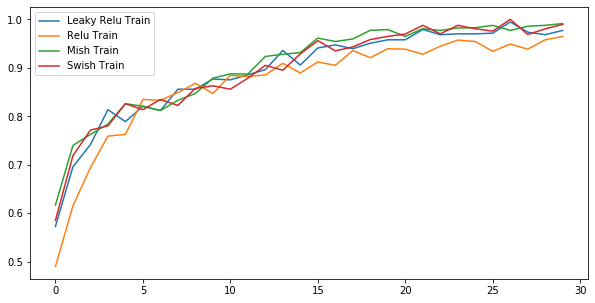

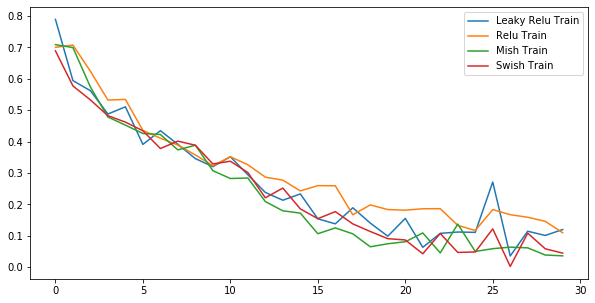

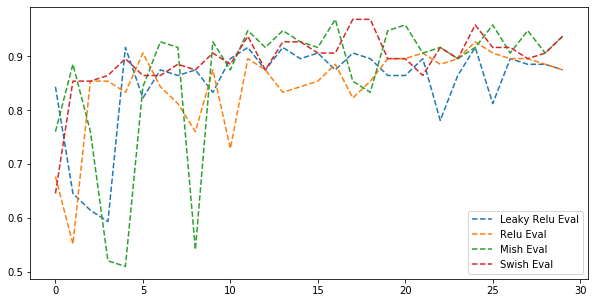

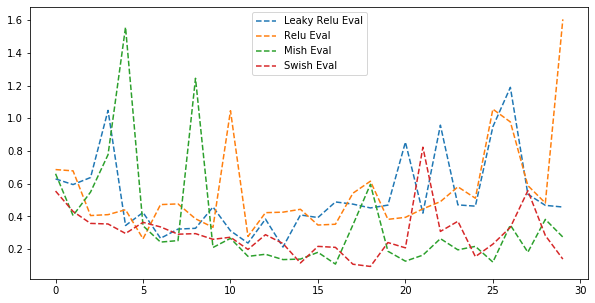

In [16]:
models = [model_leaky, model_relu, model_mish, model_swish]
model_names = ["Leaky Relu", "Relu", "Mish", "Swish"]
compare_result(models, model_names, measure='acc', plot_eval=False, save="acc_imagegen_train_custom_cnn.png")
compare_result(models, model_names, measure='loss', plot_eval=False, save="loss_imagegen_train_custom_cnn.png")
compare_result(models, model_names, measure='acc', plot_eval=True, save="acc_imagegen_test_custom_cnn.png")
compare_result(models, model_names, measure='loss', plot_eval=True, save="loss_imagegen_test_custom_cnn.png")

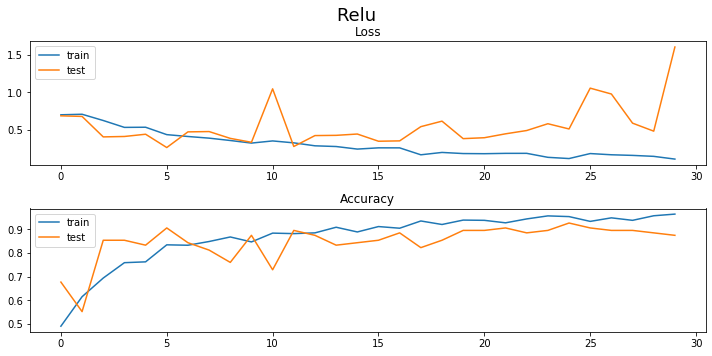

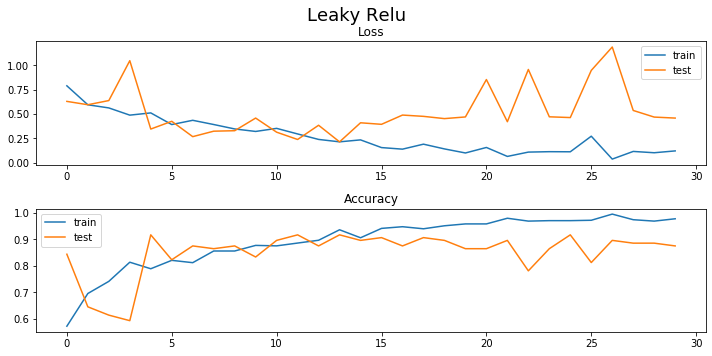

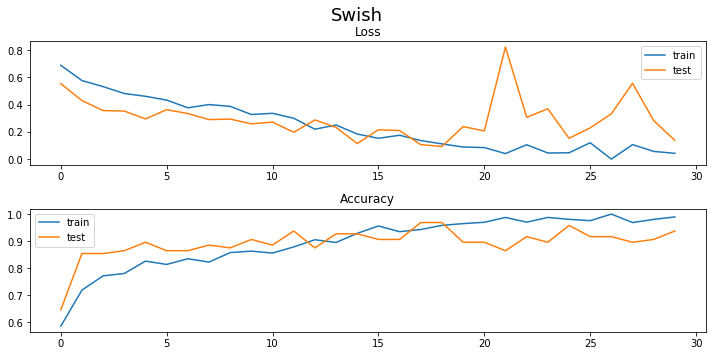

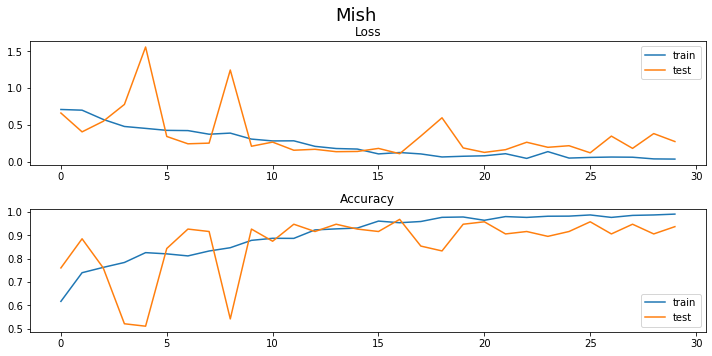

In [17]:
plot_results(model_relu, "Relu")
plot_results(model_leaky, "Leaky Relu")
plot_results(model_swish, "Swish")
plot_results(model_mish, "Mish")

**Save Results**

In [19]:
models = [model_leaky, model_relu, model_mish, model_swish]
model_names = ["Leaky Relu", "Relu", "Mish", "Swish"]
save_results(models, model_names, save_name="custom_cnn_imagegen")

# EfficientNet - Transfer Learning
https://www.dlology.com/blog/transfer-learning-with-efficientnet/

Two steps:   
1) Remove top layer and add new layers that can be trained
    * Make sure that the base cannot be trained
2) Take the top layers of the base and make them trainable again
    * This will make it possible to nudge lower layer features to be more relevant to the newly added layers and final prediction
    

In [1]:
from efficientnet.keras import EfficientNetB0
from keras import layers, models
import keras

Using TensorFlow backend.


### Load pre-trained model

In [3]:
input_shape = (150, 150, 3)
conv_base = EfficientNetB0(weights="imagenet", include_top=False, input_shape=input_shape)
conv_base.trainable = False

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


### Add additional layers for training purposes

In [4]:
dropout_rate = 0.2
model = models.Sequential()
model.add(conv_base)
model.add(layers.GlobalMaxPooling2D(name="gap"))
if dropout_rate > 0:
    model.add(layers.Dropout(dropout_rate, name="dropout_out"))
model.add(layers.Dense(1, activation="sigmoid", name="fc_out"))

In [5]:
target_size = (150, 150)
train_generator, validation_generator = create_generators(train_dir='Images/Training', 
                                                          test_dir='Images/Validation',
                                                          target_size=target_size)

Found 581 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


In [6]:
model.compile(
    loss="binary_crossentropy",
    optimizer=keras.optimizers.RMSprop(lr=2e-5),
    metrics=["acc"],
)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


## 1) Train newly added layers

In [7]:
history_old = model.fit_generator(train_generator, 
                              steps_per_epoch=train_generator.n // train_generator.batch_size, 
                              epochs=30, 
                              validation_data=validation_generator,
                              validation_steps=validation_generator.n // validation_generator.batch_size,
                              verbose=1,    
                              use_multiprocessing=True,
                              workers=4)


Epoch 1/30
48/48 [==============================] - 19s 388ms/step - loss: 1.4618 - acc: 0.5554 - val_loss: 0.7456 - val_acc: 0.5521
Epoch 2/30
48/48 [==============================] - 14s 281ms/step - loss: 1.4335 - acc: 0.5272 - val_loss: 0.9420 - val_acc: 0.5568
Epoch 3/30
48/48 [==============================] - 13s 274ms/step - loss: 1.3278 - acc: 0.5483 - val_loss: 1.2828 - val_acc: 0.5341
Epoch 4/30
48/48 [==============================] - 14s 290ms/step - loss: 1.2957 - acc: 0.5518 - val_loss: 1.1049 - val_acc: 0.5568
Epoch 5/30
48/48 [==============================] - 13s 279ms/step - loss: 1.4441 - acc: 0.5237 - val_loss: 1.0265 - val_acc: 0.5568
Epoch 6/30
48/48 [==============================] - 14s 293ms/step - loss: 1.2360 - acc: 0.5729 - val_loss: 0.8446 - val_acc: 0.6136
Epoch 7/30
48/48 [==============================] - 13s 272ms/step - loss: 1.2499 - acc: 0.5819 - val_loss: 0.9788 - val_acc: 0.5909
Epoch 8/30
48/48 [==============================] - 13s 273ms/step -

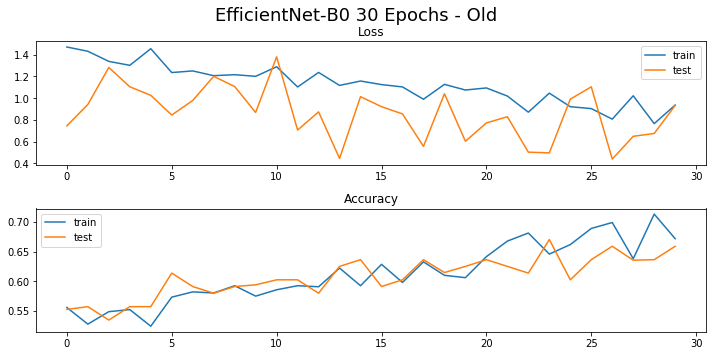

In [8]:
plot_results(model, "EfficientNet-B0 30 Epochs - Old")

## 2) Make top layers of base trainable

In [12]:
# Make top layers of conv_base trainable

conv_base.trainable = True
set_trainable = False

for layer in conv_base.layers:
    layer.trainable = False
    if layer.name == 'block7a_se_excite':
        set_trainable = True
    if set_trainable:
        layer.trainable = True

In [14]:
model.compile(
    loss="binary_crossentropy",
    optimizer=keras.optimizers.RMSprop(lr=2e-5),
    metrics=["acc"],
)

**Continue training**

In [16]:
history_new = model.fit_generator(train_generator, 
                              steps_per_epoch=train_generator.n // train_generator.batch_size, 
                              epochs=30, 
                              validation_data=validation_generator,
                              validation_steps=validation_generator.n // validation_generator.batch_size,
                              verbose=1,    
                              use_multiprocessing=True,
                              workers=4)

Epoch 1/30
48/48 [==============================] - 14s 292ms/step - loss: 0.6665 - acc: 0.7663 - val_loss: 1.1859 - val_acc: 0.6875
Epoch 2/30
48/48 [==============================] - 15s 305ms/step - loss: 0.5982 - acc: 0.7856 - val_loss: 0.5654 - val_acc: 0.6705
Epoch 3/30
48/48 [==============================] - 15s 312ms/step - loss: 0.5405 - acc: 0.8243 - val_loss: 0.4318 - val_acc: 0.8295
Epoch 4/30
48/48 [==============================] - 15s 320ms/step - loss: 0.4418 - acc: 0.8330 - val_loss: 0.4756 - val_acc: 0.7955
Epoch 5/30
48/48 [==============================] - 16s 343ms/step - loss: 0.4744 - acc: 0.8260 - val_loss: 0.8183 - val_acc: 0.8523
Epoch 6/30
48/48 [==============================] - 16s 331ms/step - loss: 0.3454 - acc: 0.8664 - val_loss: 0.5192 - val_acc: 0.8864
Epoch 7/30
48/48 [==============================] - 15s 311ms/step - loss: 0.3406 - acc: 0.8541 - val_loss: 0.0934 - val_acc: 0.9091
Epoch 8/30
48/48 [==============================] - 15s 311ms/step - 

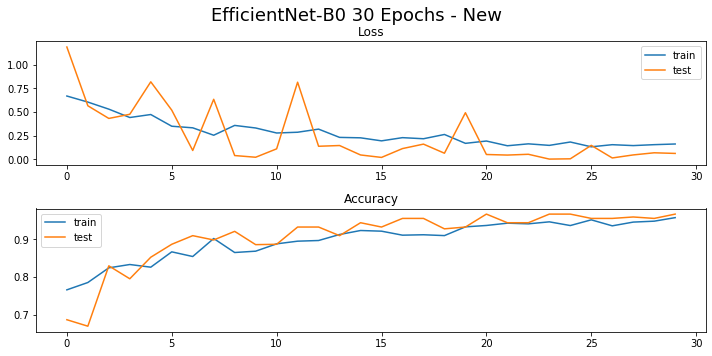

In [17]:
plot_results(model, "EfficientNet-B0 30 Epochs - New")

## Compare finetuning methods

In [ ]:
# 30 + 30 vs 60 old vs 60 new

In [23]:
history_old.history['acc'].extend(history_new.history['acc'])
history_old.history['loss'].extend(history_new.history['loss'])

In [32]:
history_new.history['acc'][:5]

[0.7662566, 0.78558874, 0.8242531, 0.8330404, 0.8260105]

In [33]:
history_old.history['acc'][:5]

[0.7662566, 0.78558874, 0.8242531, 0.8330404, 0.8260105]

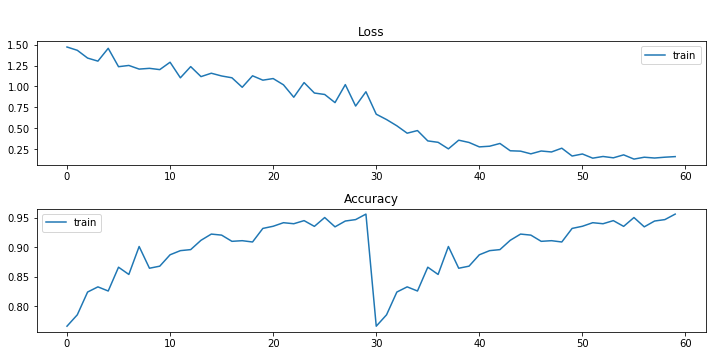

In [29]:
combined_acc = history_old.history['acc']
combined_loss = history_old.history['loss']

plt.figure(figsize=(10,5))

# plot loss during training
plt.subplot(211)
plt.suptitle("\n\n", fontsize=18)
plt.title('\nLoss')
plt.plot(combined_loss, label='train')
# plt.plot(val_loss, label='test')
plt.legend()

# plot accuracy during training
plt.subplot(212)
plt.title('Accuracy')
plt.plot(combined_acc, label='train')
# plt.plot(val_acc, label='test')
plt.legend()
plt.tight_layout()


plt.show()

## Visualize Model

In [13]:
from tensorflow.keras.utils import plot_model
# plot_model(conv_base, to_file='conv_base.png', show_shapes=True)
from IPython.display import Image
# Image(filename='conv_base.png') 

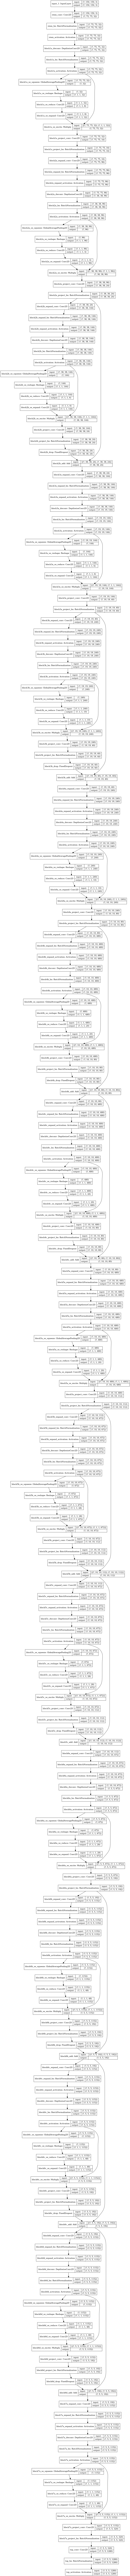

In [14]:
plot_model(conv_base, to_file='conv_base.png', show_shapes=True)


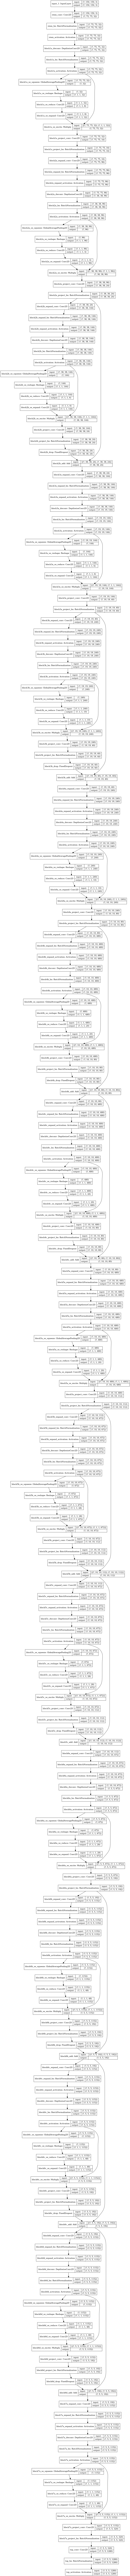

In [15]:
Image(filename='conv_base.png') 